# EPP Screening Model - Project Scenario Analysis

This notebook demonstrates how to create **comprehensive project scenarios** that combine:
- Property characteristics (size, land price)
- Operational parameters (variable costs)
- Custom ACCU production volumes (carbon sequestration curves)

This pattern is ideal for comparing different project opportunities or analyzing "what-if" scenarios.

## Prerequisites

Before running this notebook, ensure you have:
1. Installed the EPP Screening Model package (v1.1.0+)
2. Created a `config/config.toml` file with model parameters
3. Installed Jupyter dependencies: `uv sync --extra notebook`

## Setup and Imports

In [8]:
# Standard library imports
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import tomli
from pathlib import Path
from IPython.display import display

# Change to project root directory if we're in examples/
if Path.cwd().name == 'examples':
    os.chdir('..')
    print(f"Changed working directory to: {Path.cwd()}")
else:
    print(f"Working directory: {Path.cwd()}")

# Verify config file exists
config_path = Path('config/config.toml')
if config_path.exists():
    print(f"✓ Config file found: {config_path.absolute()}")
else:
    print(f"❌ Config file NOT found at: {config_path.absolute()}")
    print(f"   Please ensure config/config.toml exists in the project root")

# EPP package imports
from epp_screening_model_v3.models import ACCUModel, ModelExecutionResults
from epp_screening_model_v3.notebooks.epp_jupyter_helpers import run_model_with_scenario

# Configure pandas display
pd.set_option('display.float_format', lambda x: f'{x:,.2f}' if abs(x) >= 0.01 else f'{x:.4f}')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Ensure results directory exists
Path('results').mkdir(exist_ok=True)

print("✓ All imports successful")
print("✓ Results directory ready")

Working directory: /Users/jim/Development/Wollemi/epp-example-external-usage
✓ Config file found: /Users/jim/Development/Wollemi/epp-example-external-usage/config/config.toml
✓ All imports successful
✓ Results directory ready


---

## Project Scenario Analysis

Real project decisions involve multiple changing parameters simultaneously. Let's explore a "project expansion" scenario where we compare different property types with varying:
- Property size and cost
- Plantable area ratios  
- Variable operational costs
- Carbon sequestration efficiency (ACCU volumes)

### Step 1: Load Baseline Configuration and ACCU Volumes

In [9]:
# Load baseline configuration
with open('config/config.toml', 'rb') as f:
    config = tomli.load(f)

# Extract baseline ACCU volumes
baseline_accu_volumes = config['static']['accu_volumes_property_1']

print("Baseline Configuration:")
print("=" * 80)
print(f"Property Price: ${config['static']['config_property_price']:,.0f}/ha")
print(f"Property Area: {config['static']['config_hectares_by_project_arable_area']:,.0f} ha")
print(f"Plantable Area: {config['static']['config_hectares_by_project_plantable_area']:,.0f} ha")
print(f"Variable Cost: ${config['static']['config_variable_cost_per_hectar']:,.0f}/ha/year")
print(f"\nACCU Volumes:")
print(f"  Years: {len(baseline_accu_volumes)}")
print(f"  Total ACCUs: {sum(baseline_accu_volumes):,.0f}")
print(f"  Peak production: {max(baseline_accu_volumes):,.0f} (Year {baseline_accu_volumes.index(max(baseline_accu_volumes))})")

Baseline Configuration:
Property Price: $4,500/ha
Property Area: 1,823 ha
Plantable Area: 785 ha
Variable Cost: $4/ha/year

ACCU Volumes:
  Years: 27
  Total ACCUs: 438,460
  Peak production: 29,936 (Year 5)


### Step 2: Define Project Scenarios

We'll create 4 realistic project scenarios that vary multiple parameters:

In [10]:
# Define project expansion scenarios
# These scenarios combine property characteristics with custom ACCU curves
project_scenarios = [
    {
        'name': 'Baseline Scale',
        'property_price': 4500,
        'property_area': 1000,
        'plantable_area': 750,
        'capex_per_ha': 25,
        'accu_multiplier': 1.0,  # Use baseline ACCU volumes
        'description': 'Standard 1000ha property, 750ha plantable'
    },
    {
        'name': 'Larger Property',
        'property_price': 4200,  # Slightly lower per-ha cost at scale
        'property_area': 1500,
        'plantable_area': 1125,  # 75% plantable
        'capex_per_ha': 23,  # Economies of scale
        'accu_multiplier': 1.0,
        'description': 'Larger 1500ha property, same efficiency'
    },
    {
        'name': 'High Sequestration',
        'property_price': 5000,  # Premium land
        'property_area': 1000,
        'plantable_area': 800,  # More plantable area
        'capex_per_ha': 28,  # Higher costs for better species
        'accu_multiplier': 1.3,  # 30% more ACCU generation
        'description': 'Optimal conditions, 30% higher carbon capture'
    },
    {
        'name': 'Budget Expansion',
        'property_price': 3800,  # Lower cost land
        'property_area': 1200,
        'plantable_area': 840,  # 70% plantable
        'capex_per_ha': 22,
        'accu_multiplier': 0.9,  # 10% less efficient due to land quality
        'description': 'Cost-focused expansion, slightly lower efficiency'
    },
]

print("Project Scenarios Defined:")
print("=" * 80)
for scenario in project_scenarios:
    print(f"\n{scenario['name']}:")
    print(f"  {scenario['description']}")
    print(f"  Property: ${scenario['property_price']}/ha × {scenario['property_area']}ha = ${scenario['property_price'] * scenario['property_area']:,.0f}")
    print(f"  Plantable: {scenario['plantable_area']}ha ({scenario['plantable_area']/scenario['property_area']*100:.0f}%)")
    print(f"  Opex: ${scenario['capex_per_ha']}/ha/year")
    print(f"  ACCU Efficiency: {scenario['accu_multiplier']:.1f}x baseline")

Project Scenarios Defined:

Baseline Scale:
  Standard 1000ha property, 750ha plantable
  Property: $4500/ha × 1000ha = $4,500,000
  Plantable: 750ha (75%)
  Opex: $25/ha/year
  ACCU Efficiency: 1.0x baseline

Larger Property:
  Larger 1500ha property, same efficiency
  Property: $4200/ha × 1500ha = $6,300,000
  Plantable: 1125ha (75%)
  Opex: $23/ha/year
  ACCU Efficiency: 1.0x baseline

High Sequestration:
  Optimal conditions, 30% higher carbon capture
  Property: $5000/ha × 1000ha = $5,000,000
  Plantable: 800ha (80%)
  Opex: $28/ha/year
  ACCU Efficiency: 1.3x baseline

Budget Expansion:
  Cost-focused expansion, slightly lower efficiency
  Property: $3800/ha × 1200ha = $4,560,000
  Plantable: 840ha (70%)
  Opex: $22/ha/year
  ACCU Efficiency: 0.9x baseline


### Step 3: Run All Scenarios

Now we'll execute the model for each scenario, combining all parameter overrides:

In [11]:
print("\n" + "="*60)
print("COMBINED PROJECT SCENARIOS ANALYSIS")
print("="*60)

combined_results = []

print("\nRunning project scenarios...")
for scenario in project_scenarios:
    # Calculate custom ACCU volumes by scaling baseline
    custom_accu_volumes = [vol * scenario['accu_multiplier'] for vol in baseline_accu_volumes]
    
    # Create comprehensive scenario overrides
    scenario_overrides = {
        'static': {
            'config_property_price': scenario['property_price'],
            'config_hectares_by_project_plantable_area': scenario['plantable_area'],
            'config_fullcam_project_area': scenario['plantable_area'],
            'config_hectares_by_project_arable_area': scenario['property_area'],
            'config_hectares_by_project_carbon_area': scenario['property_area'],
            'config_variable_cost_per_hectar': scenario['capex_per_ha'],
        },
        'accu_volumes': custom_accu_volumes  # Override ACCU curve
    }
    
    # Run model
    results = run_model_with_scenario(
        config_path='config/config.toml',
        scenario=scenario_overrides,
        verbose=False
    )
    
    # Calculate total ACCUs over project life
    total_accus = sum(custom_accu_volumes)
    
    # Store results
    combined_results.append({
        'Scenario': scenario['name'],
        'Property (ha)': scenario['property_area'],
        'Plantable (ha)': scenario['plantable_area'],
        'Land ($/ha)': scenario['property_price'],
        'Capex ($/ha/yr)': scenario['capex_per_ha'],
        'ACCU Mult': f"{scenario['accu_multiplier']:.1f}x",
        'Total ACCUs': total_accus,
        'Levered IRR': results.levered_irr,
        'Unlevered IRR': results.unlevered_irr,
    })
    
    print(f"  ✓ {scenario['name']}: Levered IRR = {results.levered_irr:.2%}, Total ACCUs = {total_accus:,.0f}")

# Create DataFrame
df_combined = pd.DataFrame(combined_results)

print("\n📊 COMBINED SCENARIO RESULTS:")
print(df_combined.to_string(index=False))


COMBINED PROJECT SCENARIOS ANALYSIS

Running project scenarios...
  ✓ Baseline Scale: Levered IRR = 22.16%, Total ACCUs = 438,460
  ✓ Larger Property: Levered IRR = 23.50%, Total ACCUs = 438,460
  ✓ High Sequestration: Levered IRR = 26.01%, Total ACCUs = 569,999
  ✓ Budget Expansion: Levered IRR = 23.03%, Total ACCUs = 394,614

📊 COMBINED SCENARIO RESULTS:
          Scenario  Property (ha)  Plantable (ha)  Land ($/ha)  Capex ($/ha/yr) ACCU Mult  Total ACCUs  Levered IRR  Unlevered IRR
    Baseline Scale           1000             750         4500               25      1.0x   438,460.41         0.22           0.16
   Larger Property           1500            1125         4200               23      1.0x   438,460.41         0.23           0.17
High Sequestration           1000             800         5000               28      1.3x   569,998.54         0.26           0.19
  Budget Expansion           1200             840         3800               22      0.9x   394,614.37         0.23 

### Step 4: Analyze Results

In [12]:
# Analysis
print("\n💡 KEY INSIGHTS:")
print("=" * 80)
print(f"  • IRR Range: {df_combined['Levered IRR'].min():.2%} to {df_combined['Levered IRR'].max():.2%}")
print(f"  • ACCU Volume Range: {df_combined['Total ACCUs'].min():,.0f} to {df_combined['Total ACCUs'].max():,.0f}")

# Find best scenario
best_idx = df_combined['Levered IRR'].idxmax()
best_scenario = df_combined.iloc[best_idx]
print(f"\n🏆 BEST SCENARIO: {best_scenario['Scenario']}")
print(f"  • Returns highest Levered IRR: {best_scenario['Levered IRR']:.2%}")
print(f"  • Property: {best_scenario['Property (ha)']:.0f}ha ({best_scenario['Plantable (ha)']:.0f}ha plantable)")
print(f"  • Total ACCUs: {best_scenario['Total ACCUs']:,.0f}")

# Compare baseline to high sequestration
baseline_idx = 0
high_seq_idx = 2
if len(combined_results) >= 3:
    baseline_irr = df_combined.iloc[baseline_idx]['Levered IRR']
    high_seq_irr = df_combined.iloc[high_seq_idx]['Levered IRR']
    irr_improvement = (high_seq_irr - baseline_irr) * 100
    
    print(f"\n📈 HIGH SEQUESTRATION vs BASELINE:")
    print(f"  • 30% more ACCUs generates {irr_improvement:+.0f} basis points IRR improvement")
    print(f"  • Higher upfront costs ($5000/ha vs $4500/ha) partially offset by better carbon capture")


💡 KEY INSIGHTS:
  • IRR Range: 22.16% to 26.01%
  • ACCU Volume Range: 394,614 to 569,999

🏆 BEST SCENARIO: High Sequestration
  • Returns highest Levered IRR: 26.01%
  • Property: 1000ha (800ha plantable)
  • Total ACCUs: 569,999

📈 HIGH SEQUESTRATION vs BASELINE:
  • 30% more ACCUs generates +4 basis points IRR improvement
  • Higher upfront costs ($5000/ha vs $4500/ha) partially offset by better carbon capture


### Step 5: Visualize Scenario Comparison

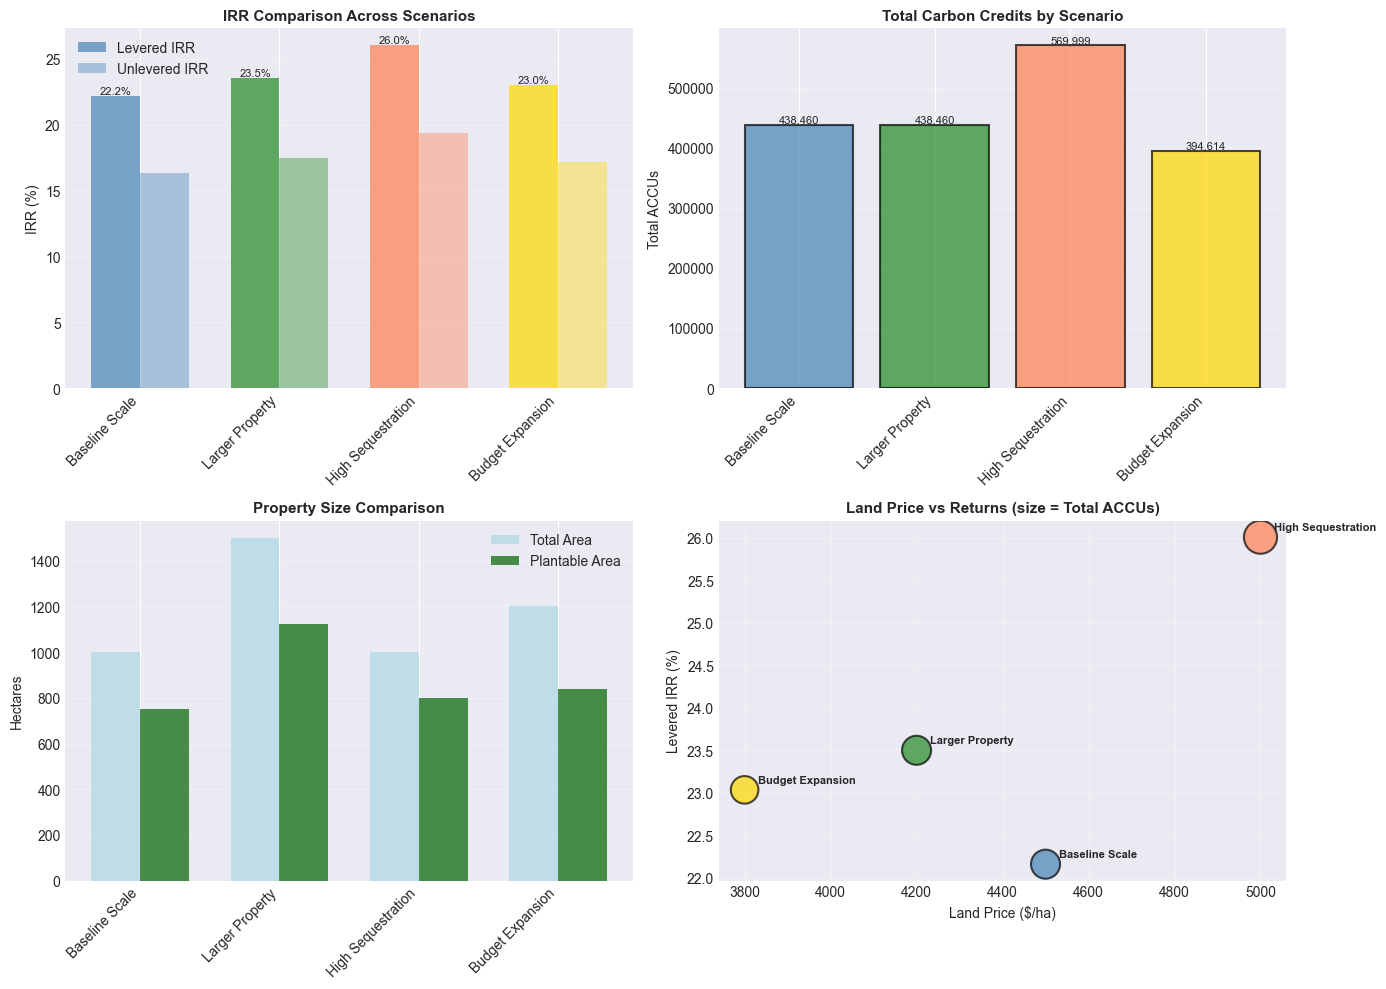

✓ Chart saved: results/project_scenario_analysis.png


In [13]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define colors for each scenario
colors = ['steelblue', 'forestgreen', 'coral', 'gold']

# Plot 1: IRR Comparison
ax1 = axes[0, 0]
x = range(len(df_combined))
width = 0.35
bars1 = ax1.bar([i - width/2 for i in x], df_combined['Levered IRR'] * 100, 
                width, label='Levered IRR', color=colors, alpha=0.7)
bars2 = ax1.bar([i + width/2 for i in x], df_combined['Unlevered IRR'] * 100,
                width, label='Unlevered IRR', color=colors, alpha=0.4)
ax1.set_ylabel('IRR (%)', fontsize=10)
ax1.set_title('IRR Comparison Across Scenarios', fontsize=11, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_combined['Scenario'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

# Plot 2: Total ACCUs by Scenario
ax2 = axes[0, 1]
bars = ax2.bar(df_combined['Scenario'], df_combined['Total ACCUs'], 
               color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Total ACCUs', fontsize=10)
ax2.set_title('Total Carbon Credits by Scenario', fontsize=11, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:,.0f}', ha='center', va='bottom', fontsize=8)

# Plot 3: Property Characteristics
ax3 = axes[1, 0]
x = range(len(df_combined))
width = 0.35
bars1 = ax3.bar([i - width/2 for i in x], df_combined['Property (ha)'],
                width, label='Total Area', color='lightblue', alpha=0.7)
bars2 = ax3.bar([i + width/2 for i in x], df_combined['Plantable (ha)'],
                width, label='Plantable Area', color='darkgreen', alpha=0.7)
ax3.set_ylabel('Hectares', fontsize=10)
ax3.set_title('Property Size Comparison', fontsize=11, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(df_combined['Scenario'], rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Land Cost vs IRR
ax4 = axes[1, 1]
scatter = ax4.scatter(df_combined['Land ($/ha)'], df_combined['Levered IRR'] * 100,
                     s=df_combined['Total ACCUs']/1000, c=colors, alpha=0.7,
                     edgecolors='black', linewidth=1.5)
for idx, row in df_combined.iterrows():
    ax4.annotate(row['Scenario'],
                (row['Land ($/ha)'], row['Levered IRR'] * 100),
                xytext=(10, 5), textcoords='offset points',
                fontsize=8, fontweight='bold')
ax4.set_xlabel('Land Price ($/ha)', fontsize=10)
ax4.set_ylabel('Levered IRR (%)', fontsize=10)
ax4.set_title('Land Price vs Returns (size = Total ACCUs)', fontsize=11, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/project_scenario_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Chart saved: results/project_scenario_analysis.png")

### Step 6: Export Results

In [14]:
# Export to CSV
df_combined.to_csv('results/project_scenarios.csv', index=False)
print("✓ Saved CSV: results/project_scenarios.csv")

# Export to Excel with formatting
with pd.ExcelWriter('results/project_scenarios.xlsx', engine='openpyxl') as writer:
    df_combined.to_excel(writer, index=False, sheet_name='Scenarios')
    
    # Get the worksheet
    worksheet = writer.sheets['Scenarios']
    
    # Auto-adjust column widths
    for column in worksheet.columns:
        max_length = 0
        column = [cell for cell in column]
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2)
        worksheet.column_dimensions[column[0].column_letter].width = adjusted_width

print("✓ Saved Excel: results/project_scenarios.xlsx")

print("\n" + "="*80)
print("💡 KEY TAKEAWAY:")
print("="*80)
print("This demonstrates how to model complete project scenarios by combining:")
print("  1. Property characteristics (size, land price)")
print("  2. Operational parameters (capex per hectare)")
print("  3. Carbon sequestration curves (custom ACCU volumes)")
print("\nUse this pattern for real-world project comparisons!")
print("="*80)

✓ Saved CSV: results/project_scenarios.csv
✓ Saved Excel: results/project_scenarios.xlsx

💡 KEY TAKEAWAY:
This demonstrates how to model complete project scenarios by combining:
  1. Property characteristics (size, land price)
  2. Operational parameters (capex per hectare)
  3. Carbon sequestration curves (custom ACCU volumes)

Use this pattern for real-world project comparisons!


---

## Summary

This notebook demonstrated:

1. **Combined Parameter Scenarios**: Modifying multiple static parameters simultaneously
2. **Custom ACCU Volumes**: Scaling baseline carbon production by efficiency multipliers
3. **Comprehensive Analysis**: Comparing property sizes, costs, and carbon capture efficiency
4. **Visualization**: Creating informative comparison charts
5. **Export**: Saving results for further analysis

### Use Cases

This approach is ideal for:
- **Portfolio Analysis**: Comparing multiple acquisition opportunities
- **Feasibility Studies**: Testing different project configurations
- **Investor Presentations**: Showing scenario ranges and sensitivities
- **Risk Assessment**: Understanding parameter impacts on returns

### Next Steps

- Add more scenarios with different parameter combinations
- Incorporate goal seek to find optimal parameters
- Test sensitivity to ACCU pricing assumptions
- Export scenarios as TOML files for future reference

### Resources

- [README.md](../README.md) - Full project documentation
- [Python Examples](.) - Additional example scripts
- [EPP Package Repository](https://github.com/MullionGroup/epp_screening_model_v3) - Main package source